# **East Africa drought study - sensitivity of SPEI to PET formulation**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

# for SPEI fitting
from xclim.indices.stats import fit        # used in estimating SPI/SPEI parameters over DataArray
import lmoments3.distr                     # pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo") 

# load shapefile used to extract time series from gridded data
sf = gpd.read_file("sf_gha")

import json     # for loading lists produced in R

---
## **Data pre-processing**

In [2]:
lsm = xr.open_dataset("../../Data/era5/era5_lsm_025.nc").sel(longitude = slice(35,52), latitude = slice(8,-6)).squeeze(drop = True).rename(latitude = "lat", longitude = "lon").dropna("lon", "all").lsm

In [ ]:
xr.open_dataset("../../Data/era5/era5_tmax_daily_af.nc").tmax.sel(lon = lsm.lon, lat = lsm.lat).where(lsm >= 0.5).to_netcdf("spei/era5_tmax_daily.nc")
xr.open_dataset("../../Data/era5/era5_tmin_daily_af.nc").tmin.sel(lon = lsm.lon, lat = lsm.lat).where(lsm >= 0.5).to_netcdf("spei/era5_tmin_daily.nc")

In [ ]:
xr.open_dataset("data/cpc_tmax.nc").tmax

---
## **ERA5**

### **Compute gridded PET**

In [97]:
tmax = xr.open_dataset("spei/era5_tmax_daily.nc").tmax
tmin = xr.open_dataset("spei/era5_tmin_daily.nc").tmin

In [99]:
br65 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "BR65"), "mm/day").rename("pet")
br65.to_netcdf("spei/era5_pet-br65_daily.nc")
br65.resample(time = "MS").sum().to_netcdf("spei/era5_pet-br65_monthly.nc")

In [100]:
hg85 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "HG85"), "mm/day").rename("pet")
hg85.to_netcdf("spei/era5_pet-hg85_daily.nc")
hg85.resample(time = "MS").sum().to_netcdf("spei/era5_pet-hg85_monthly.nc")

In [5]:
tw48 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "TW48"), "mm/month").rename("pet")
tw48.to_netcdf("spei/era5_pet-tw48_monthly.nc")

In [6]:
# # McGuinness-Bordne calibration parameters for Africa are unknown, so can't use
# mb05 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "MB05"), "mm/day").rename("pet")
# mb05.to_netcdf("spei/era5_pet-mb05_daily.nc")

### **PET & SPEI time series**

In [22]:
# quick fitting method
def spei(ts):
    
    ts_cal = ts.sel(time = slice("1980", "2010")).copy()
    spei_pars = glo.lmom_fit(ts_cal)
    spei24 = norm.ppf(glo.cdf(ts, *spei_pars.values()))
    return xr.DataArray(data = spei24, dims = ["time"], coords = {"time" : ts.time.dt.year}, name = "spei").rename(time = "year")

In [23]:
# get time series of 24-month accumulated climatic water balance
pr = xr.open_dataset("spei/era5_pr_monthly.nc").tp.mean("expver").rename(latitude = "lat", longitude = "lon")
pr24 = convert_units_to(pr * pr.time.dt.daysinmonth, "mm").rolling(time = 24).sum().groupby("time.month")[12]
pr24_ts = pr24.where(regionmask.mask_3D_geopandas(sf, pr24.lon, pr24.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).dropna("time", "any")

pet24 = {fnm.split("-")[1][:4] : xr.open_dataset(fnm).pet.resample(time = "MS").sum().rolling(time = 24).sum().groupby("time.month")[12] for fnm in sorted(glob.glob("spei/era5_pet-*.nc"))}
pet24_ts = {k : da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).dropna("time", "any") for k, da in pet24.items()}

effpr24_ts = {k : pr24_ts - ts for k, ts in pet24_ts.items()}

spei24_ts = {k : spei(ts) for k, ts in effpr24_ts.items()}

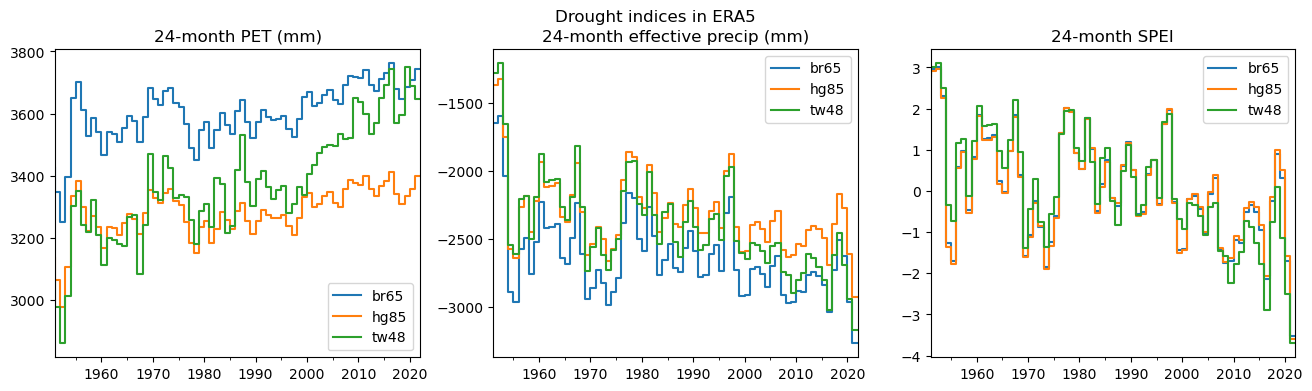

In [53]:
fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100)

pd.DataFrame(pet24_ts, index = pet24_ts["br65"].time).plot(ax = axs[0], drawstyle = "steps")
axs[0].set_title("24-month PET (mm)")

pd.DataFrame(effpr24_ts, index = effpr24_ts["br65"].time).plot(ax = axs[1], drawstyle = "steps")
axs[1].set_title("24-month effective precip (mm)")

pd.DataFrame(spei24_ts, index = effpr24_ts["br65"].time).plot(ax = axs[2], drawstyle = "steps")
axs[2].set_title("24-month SPEI")

plt.suptitle("Drought indices in ERA5")

plt.savefig("spei/fig_era5_pet-spei.png")

In [24]:
[ts.to_pandas().to_csv("spei/era5_spei24-"+k+".csv") for k, ts in spei24_ts.items()]
[ts.assign_coords(time = ts.time.dt.year).to_pandas().to_csv("spei/era5_pet24-"+k+".csv") for k, ts in pet24_ts.items()]
pr24_ts.assign_coords(time = pr24_ts.time.dt.year).to_pandas().to_csv("spei/era5_pr24.csv")

---
## **CPC**

### **Compute gridded PET**

In [101]:
tmax = xr.open_dataset("data/cpc_tmax.nc").tmax
tmin = xr.open_dataset("data/cpc_tmin.nc").tmin

In [102]:
br65 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "BR65"), "mm/day").rename("pet")
br65.to_netcdf("spei/cpc_pet-br65_daily.nc")
br65.resample(time = "MS").sum().to_netcdf("spei/cpc_pet-br65_monthly.nc")

In [103]:
hg85 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "HG85"), "mm/day").rename("pet")
hg85.to_netcdf("spei/cpc_pet-hg85_daily.nc")
hg85.resample(time = "MS").sum().to_netcdf("spei/cpc_pet-hg85_monthly.nc")

In [134]:
tw48 = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "TW48"), "mm/month").rename("pet")
tw48.to_netcdf("spei/cpc_pet-tw48_monthly.nc")

### **PET24 time series**

In [14]:
# quick fitting method
def spei(ts):
    
    ts_cal = ts.sel(time = slice("1980", "2010")).copy()
    spei_pars = glo.lmom_fit(ts_cal)
    spei24 = norm.ppf(glo.cdf(ts, *spei_pars.values()))
    return xr.DataArray(data = spei24, dims = ["time"], coords = {"time" : ts.time.dt.year}, name = "spei").rename(time = "year")

In [15]:
# get time series of 24-month accumulated climatic water balance
pr = xr.open_dataset("data/cpc_pr_monthly.nc").precip

pr24 = pr.rolling(time = 24).sum().groupby("time.month")[12]
pr24_ts = pr24.where(regionmask.mask_3D_geopandas(sf, pr24.lon, pr24.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).dropna("time", "any")

pet24 = {fnm.split("-")[1][:4] : xr.open_dataset(fnm).pet.resample(time = "MS").sum().rolling(time = 24).sum().groupby("time.month")[12] for fnm in sorted(glob.glob("spei/cpc_pet-*.nc"))}
pet24_ts = {k : da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]).dropna("time", "any") for k, da in pet24.items()}

effpr24_ts = {k : pr24_ts - ts for k, ts in pet24_ts.items()}

spei24_ts = {k : spei(ts) for k, ts in effpr24_ts.items()}

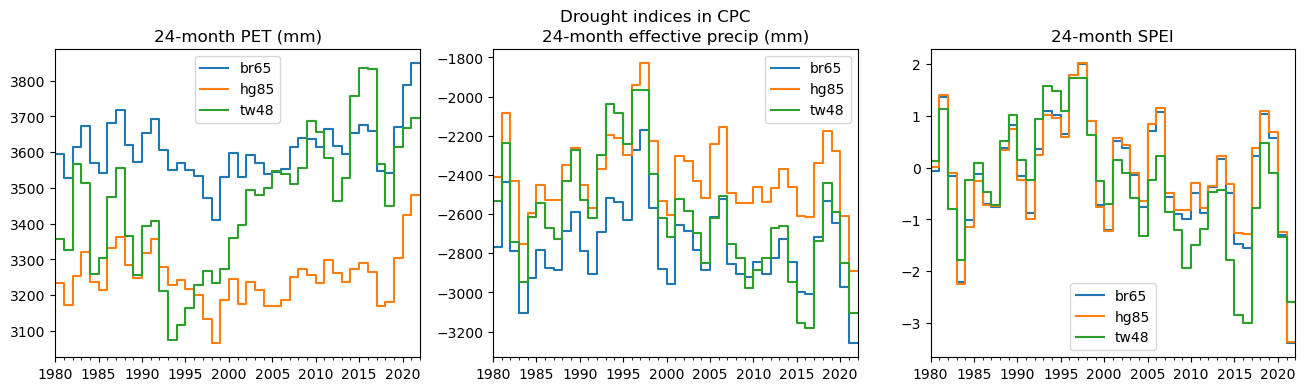

In [46]:
fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100)

pd.DataFrame(pet24_ts, index = pet24_ts["br65"].time).plot(ax = axs[0], drawstyle = "steps")
axs[0].set_title("24-month PET (mm)")

pd.DataFrame(effpr24_ts, index = effpr24_ts["br65"].time).plot(ax = axs[1], drawstyle = "steps")
axs[1].set_title("24-month effective precip (mm)")

pd.DataFrame(spei24_ts, index = effpr24_ts["br65"].time).plot(ax = axs[2], drawstyle = "steps")
axs[2].set_title("24-month SPEI")

plt.suptitle("Drought indices in CPC")

plt.savefig("spei/fig_cpc_pet-spei.png")

In [16]:
[ts.assign_coords(time = ts.time.dt.year).to_pandas().to_csv("spei/cpc_spei24-"+k+".csv") for k, ts in spei24_ts.items()]
[ts.assign_coords(time = ts.time.dt.year).to_pandas().to_csv("spei/cpc_pet24-"+k+".csv") for k, ts in pet24_ts.items()]

pr24_ts.assign_coords(time = pr24_ts.time.dt.year).to_pandas().to_csv("spei/cpc_pr24.csv")

AttributeError: 'DataArray' object has no attribute 'time'

In [21]:
[ts.assign_coords(time = ts.time.dt.year).to_pandas().to_csv("spei/cpc_pet24-"+k+".csv") for k, ts in pet24_ts.items()]


[None, None, None]

## **Plot joint contours**

In [93]:
pet = "br65"
ds = "cpc"

pet_nm = {"hg85" : "Hargreaves", "br65" : "Baier-Robertson", "tw48" : "Thornthwaite"}[pet]

cf = {"hg85" : [(1400,3400), (1400,3375), (1400,3350), (1400,3300)],
      "br65" : [(1400,3800), (1400,3750), (1400,3725), (1400,3700)], 
      "tw48" : [(1400,4000), (1400,3900), (1400,3800), (1400,3500)]}[pet]

ccf = {"hg85" : [(1200,3375), (1200,3350), (1200,3300), (1200,3300)],
       "br65" : [(1200,3675), (1200,3650), (1200,3625), (1200,3600)], 
       "tw48" : [(1200,3300), (1200,3250), (1200,3200), (1200,3100)]}[pet]

# dummy plot just to pick up the colourbar
drought_cbar = drought_map(xr.open_dataset("data/cpc_spei24.nc").spei.sel(time = "2022")); plt.close()

In [94]:
# load copula meshes (computed in R)
with open("spei/joint-fit_pr-24_pet-24_"+ds+"-"+pet+".json") as f:
    coef, rl_pr, rl_pet, contour_now, contour_cf = json.load(f).values()

    
# load precip & PET, calculate effective precip; use this to compute SPEI over regular grid of pr & pet
df = pd.merge(pd.read_csv("spei/"+ds+"_pr24.csv", index_col = 0).rename(columns = {"0" : "pr"}),
              pd.read_csv("spei/"+ds+"_pet24-"+pet+".csv", index_col = 0).rename(columns = {"0" : "pet"}),
              left_index = True, right_index = True)

df["effpr"] = df.pr - df.pet

# compute SPEI on regular grid
spei24_pars = glo.lmom_fit(df.loc[slice("1980", "2010"), "effpr"].copy()).values()
spei_grid = np.array([[norm.ppf(glo.cdf(p - pet, *spei24_pars)) for p in contour_now["x"]] for pet in contour_now["y"]])

/tmp/ipykernel_41510/2477461462.py:7: RuntimeWarning: divide by zero encountered in divide
  cs = axs.contour(contour_now["x"], contour_now["y"], 1/np.array(contour_now["z"]).transpose(), levels = yy, colors = "k")
/tmp/ipykernel_41510/2477461462.py:10: RuntimeWarning: divide by zero encountered in divide
  cs_hist = axs.contour(contour_cf["x"], contour_cf["y"], 1/np.array(contour_cf["z"]).transpose(), levels = yy, colors = "darkblue", linestyles = "--")


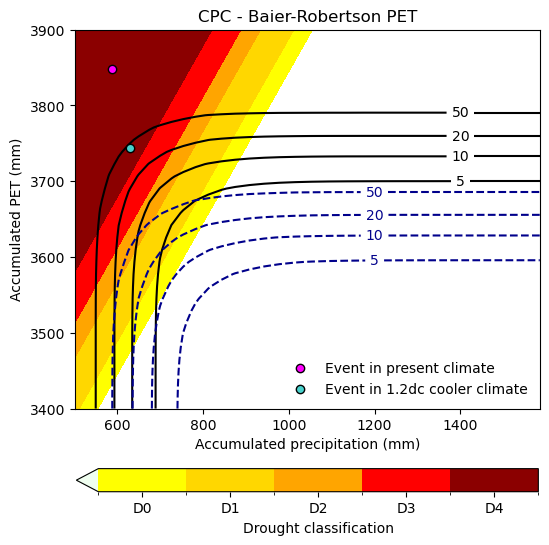

In [95]:
# plot the contours (some cleaning needed)
fig, axs = plt.subplots(ncols = 1, figsize = (6,6), dpi = 100)
yy = [5,10,20,50]

axs.contourf(contour_now["x"], contour_now["y"], spei_grid, levels = [-np.inf, -2, -1.55, -1.25, -.75, -.5], colors = ['darkred', 'red', 'orange', 'gold','yellow','honeydew'])

cs = axs.contour(contour_now["x"], contour_now["y"], 1/np.array(contour_now["z"]).transpose(), levels = yy, colors = "k")
plt.clabel(cs, levels = yy, manual = cf)

cs_hist = axs.contour(contour_cf["x"], contour_cf["y"], 1/np.array(contour_cf["z"]).transpose(), levels = yy, colors = "darkblue", linestyles = "--")
plt.clabel(cs_hist, levels = yy, manual = ccf)

axs.scatter(rl_pr["2022"][0], rl_pet["2022"], marker = "o", color = "magenta", edgecolor = "k", zorder = 10, label = "Event in present climate")
axs.scatter(rl_pr["hist"][0], rl_pet["hist"], marker = "o", color = "mediumturquoise", edgecolor = "k", zorder = 10, label = "Event in 1.2dc cooler climate")

axs.set_xlabel("Accumulated precipitation (mm)")
axs.set_ylabel("Accumulated PET (mm)")

axs.legend(loc = "lower right", edgecolor = "w")
drought_colorbar(drought_cbar, axs, fraction = 0.05, pad = 0.13, label = "Drought classification")

plt.title(ds.upper()+" - "+pet_nm+" PET")

plt.savefig("spei/fig_contours-"+ds+"-"+pet+".png")

## **Event definition maps**

### **Gridded SPI & SPEI for plotting**

In [127]:
peti = "tw48"
ds = "cpc"

# load monthly data
pr = xr.open_dataset("data/"+ds+"_pr_monthly.nc").precip
pet = xr.open_dataset("spei/"+ds+"_pet-"+peti+"_monthly.nc").pet

pr_24 = pr.rolling(time = 24, center = False).sum(keep_attrs = False).groupby("time.month")[12].where(pr.sum("time") > 0).dropna("time", "all")
eff_pr_24 = (pr - pet).rolling(time = 24, center = False).sum(keep_attrs = False).groupby("time.month")[12].dropna("time", "all")

# estimate parameters for calibration period
# NB necessary to copy calibration data to avoid reordering original
spei24_pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())),            # apply this function over each grid cell
                             eff_pr_24.sel(time = slice("1980", "2010")),                             # data for function to be applied over
                             input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])

# calculate SPEI per grid cell
spei = xr.apply_ufunc(lambda eff_pr, dparams : norm.ppf(glo.cdf(eff_pr, *dparams)),     # apply this function over each grid cell
                          eff_pr_24, spei24_pars,                                                    # provide data & parameters per grid cell
                          input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = eff_pr_24.time)

# fill in any missing values where CDF could not be computed (replace with local max/min)
spei = xr.concat([(xr.ones_like(spei) * np.floor(spei.min(["lat", "lon"]))).where(np.logical_and(eff_pr_24 < eff_pr_24.mean(), np.isnan(spei))),
                  spei,
                  (xr.ones_like(spei) * np.ceil(spei.max(["lat", "lon"]))).where(np.logical_and(eff_pr_24 > eff_pr_24.mean(), np.isnan(spei)))], "new").sum("new")

spei.rename("spei").to_netcdf("spei/"+ds+"_gridded-spei24-"+peti+".nc")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/lmoments3/distr.py:159: RuntimeWarning: invalid value encountered in power
  u = np.where(k == 0, np.exp(-x), (1. - k * x) ** (1. / k))


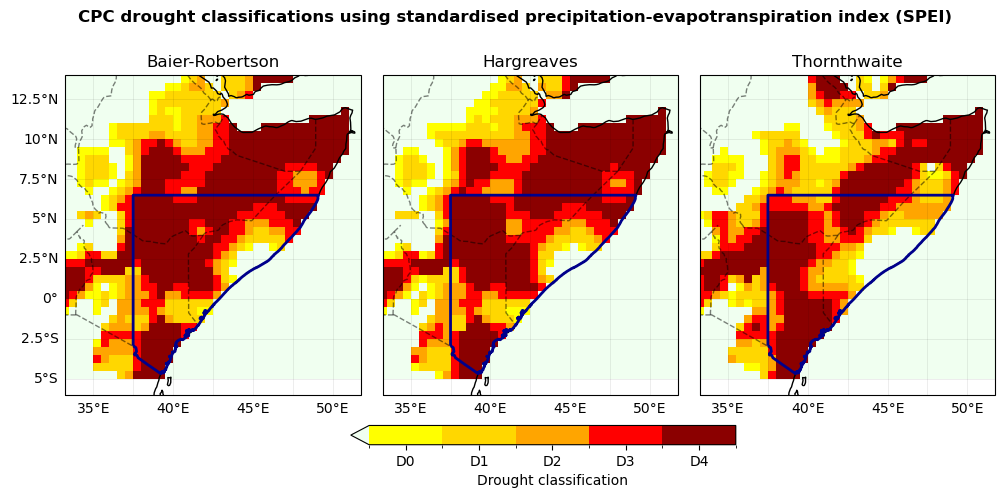

In [134]:
spei = [xr.open_dataset("spei/"+ds+"_gridded-spei24-"+peti+".nc").isel(time = -1).spei for peti in ["br65", "hg85", "tw48"]]

fig, axs = plt.subplots(ncols = 3, figsize = (12,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (33.25,51.75,-6,14)})
plt.subplots_adjust(wspace = 0.075)

for i in range(3):
    
    ax = axs[i]
    cbar = drought_map(spei[i], ax = axs[i])
    
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
    ax.set_title(["Baier-Robertson", "Hargreaves", "Thornthwaite"][i])

drought_colorbar(cbar, axs, fraction = 0.05, pad = 0.08, label = "Drought classification")
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)

plt.suptitle("CPC drought classifications using standardised precipitation-evapotranspiration index (SPEI)", fontweight = "bold")
plt.savefig("spei/fig1_event-map_cpc-spei-drought-severity.png")